In [1]:
from data.generator import generate_batch, get_vocab_size
from model.lstm import LSTM
from utils.rnn_utils import get_mask, get_hidden_mask, reduce_lens, save_states, populate_first_output, build_first_output

import torch
import seaborn as sns

In [2]:
MAX_ITER = 1000
BS = 32
LR = 0.001
LEN = 1
NES = 1
HID_SIZE = 100
DEVICE = 'cuda'

In [3]:
model = LSTM(
    input_size=get_vocab_size(),
    hidden_size=HID_SIZE,
    output_size=get_vocab_size(),
    batch_size=BS).to(DEVICE)

loss = torch.nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.Adam(model.parameters(), lr=LR)

In [4]:
padded_samples_batch, padded_targets_batch, samples_len, targets_len = generate_batch(length=LEN, nesting=NES, batch_size=BS)
padded_samples_batch, padded_targets_batch = padded_samples_batch.to(DEVICE), padded_targets_batch.to(DEVICE)

In [5]:
def batch_acc(outputs, target, loss_masks):
    masked_outputs = torch.concat(
        [(output.argmax(1)*mask).unsqueeze(1) for output, mask in zip(outputs, loss_masks)], dim=1)
    not_valid_outputs = (masked_outputs == 0).sum()
    valid_outputs = (masked_outputs != 0).sum()
    outputs_equal_to_targets = (masked_outputs == target.argmax(2)).sum()
    return (outputs_equal_to_targets - not_valid_outputs)/valid_outputs

In [6]:
def step(model, sample, target, samples_len, targets_len, loss, opt, device):
    opt.zero_grad()
    model.train()
    outputs = []
    first_output = {}
    h_dict, c_dict = {}, {}
    samples_len = samples_len.copy()
    targets_len = targets_len.copy()
    hid_size = model.h_t_1.size(1)

    for char_pos in range(sample.size(1)):
        hidden_mask = get_hidden_mask(samples_len, hid_size, device)
        output = model(sample[:, char_pos, :].squeeze(), hidden_mask)
        samples_len = reduce_lens(samples_len)
        h_dict, c_dict = save_states(model, h_dict, c_dict, samples_len)
        first_output = populate_first_output(output, samples_len, first_output)
    outputs.append(build_first_output(first_output))

    model.set_states(h_dict, c_dict)

    targets_len_copy = targets_len.copy()
    for char_pos in range(target.size(1) - 1):
        hidden_mask = get_hidden_mask(targets_len_copy, hid_size, device)
        output = model(target[:, char_pos, :].squeeze(), hidden_mask)
        targets_len_copy = reduce_lens(targets_len_copy)
        outputs.append(output)

    count_nonzero = 0
    cumulative_loss = 0
    loss_masks = []
    for char_pos, output in enumerate(outputs):
        loss_masks.append(get_mask(targets_len, device))
        targets_len = reduce_lens(targets_len)
        char_loss = loss(output, torch.argmax(target[:, char_pos, :].squeeze(), dim=1)) * loss_masks[-1]
        count_nonzero += (char_loss != 0).sum()
        cumulative_loss += torch.sum(char_loss)
    avg_loss = cumulative_loss / count_nonzero
    acc = batch_acc(outputs, target, loss_masks)

    avg_loss.backward()
    opt.step()

    model.detach_states()
    return avg_loss.item(), acc.item()

In [7]:
loss_values = []
acc_values = []

In [8]:
for i in range(MAX_ITER):
    loss_value, acc_value = step(model, padded_samples_batch, padded_targets_batch, samples_len, targets_len, loss, opt, DEVICE)
    loss_values.append(loss_value)
    acc_values.append(acc_value)
    if i % 100 == 0: print(int(i//100), end='')

0123456789

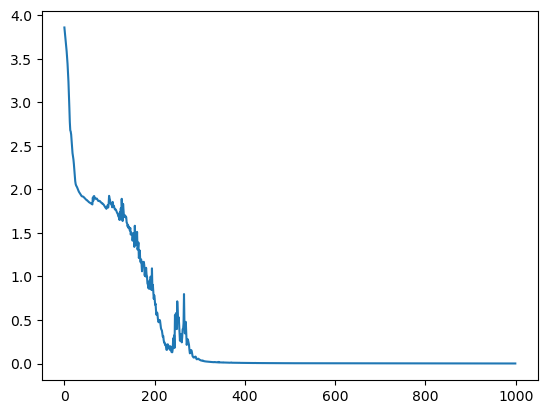

In [9]:
_ = sns.lineplot(loss_values)

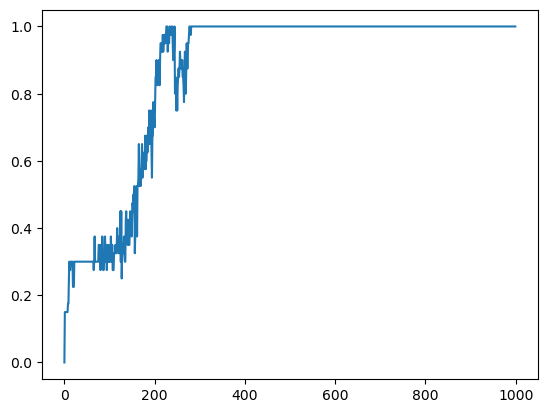

In [10]:
_ = sns.lineplot(acc_values)